# Fine tune DNN parameters

### Note that you have to execute the first 4 cells and then you can execute each part of this notebook separately

This notebook's aim is to find appropriate parameters and the best loss function for the implemented deep neural network which optimize training speed and provide a coherent, diversified trading strategy. We experiment with the first 7 months of data (6 months for training and 1 month for testing) as this will be the rolling window used in the final strategy.

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload


In [2]:
# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=2000000, low_quantile=0.005, up_quantile=0.995)
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
1841513,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,-0.006535
1841514,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,-0.006535
1841515,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,-0.006535
1841516,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,-0.006535


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
706883     2000-06
889939     2000-07
1056371    2000-08
1248826    2000-09
1415409    2000-10
1598244    2000-11
1771577    2000-12
Name: year_month, dtype: period[M]

## First run: 50 epochs, regularized softmax loss function

In [5]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [6]:
epochs = 10
max_weight = 0.05  # No stock >5% weight
diversification_lambda = 0.01  # Strength of penalty
temperature = 1.0  # Softmax temperature (lower = more diversification)
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)

Starting training with 435 train batches, 41 test batches


Training:  10%|███▍                              | 1/10 [00:15<02:21, 15.67s/it]

Epoch 1/10, Loss: -0.0712, Train Sharpe: 0.0105, Test Sharpe: -0.0135, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  30%|██████████▏                       | 3/10 [00:47<01:49, 15.70s/it]

Epoch 3/10, Loss: -0.0828, Train Sharpe: 0.0303, Test Sharpe: 0.0124, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  50%|█████████████████                 | 5/10 [01:17<01:17, 15.46s/it]

Epoch 5/10, Loss: -0.1062, Train Sharpe: 0.0480, Test Sharpe: 0.0309, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  70%|███████████████████████▊          | 7/10 [01:48<00:46, 15.52s/it]

Epoch 7/10, Loss: -0.1152, Train Sharpe: 0.0542, Test Sharpe: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  90%|██████████████████████████████▌   | 9/10 [02:19<00:15, 15.42s/it]

Epoch 9/10, Loss: -0.1195, Train Sharpe: 0.0585, Test Sharpe: 0.0405, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|█████████████████████████████████| 10/10 [02:34<00:00, 15.46s/it]

Epoch 10/10, Loss: -0.1218, Train Sharpe: 0.0602, Test Sharpe: 0.0408, Avg Weight: 0.0002, Max Weight: 0.0023
Training completed! Best test Sharpe ratio: 0.0408


In [8]:
'''
TC_RATE = 0.002 # Fixed transaction costs

test_df['weight'] = weights.values  # Current weights
# Deduct costs every day
test_df['tc_cost'] = np.abs(test_df['weight'].diff().fillna(0.0)) * TC_RATE
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
'''
TC_RATE = 0.003

test_df['weight'] = weights.values
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))


test_df['tc_cost'] = test_df['weight_change'].apply(utils.progressive_cost) * TC_RATE
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']

#test_df['weight_change'].describe()
test_df['strategy_return'].describe()

count    1.664320e+05
mean     1.168871e-07
std      2.447254e-05
min     -3.157314e-04
25%     -2.321943e-06
50%     -4.114357e-07
75%      3.053671e-07
max      4.091156e-04
Name: strategy_return, dtype: float64

In [9]:
mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
mean_daily_returns

date
2000-07-03    0.008949
2000-07-05   -0.005655
2000-07-06    0.011962
2000-07-07    0.014503
2000-07-10    0.009339
2000-07-11    0.000143
2000-07-12    0.029727
2000-07-13    0.009692
2000-07-14    0.019830
2000-07-17    0.013073
2000-07-18    0.002419
2000-07-19   -0.015026
2000-07-20    0.012598
2000-07-21   -0.008935
2000-07-24   -0.024635
2000-07-25   -0.005062
2000-07-26   -0.008306
2000-07-27   -0.028443
2000-07-28   -0.039300
2000-07-31    0.022580
Name: strategy_return, dtype: float64

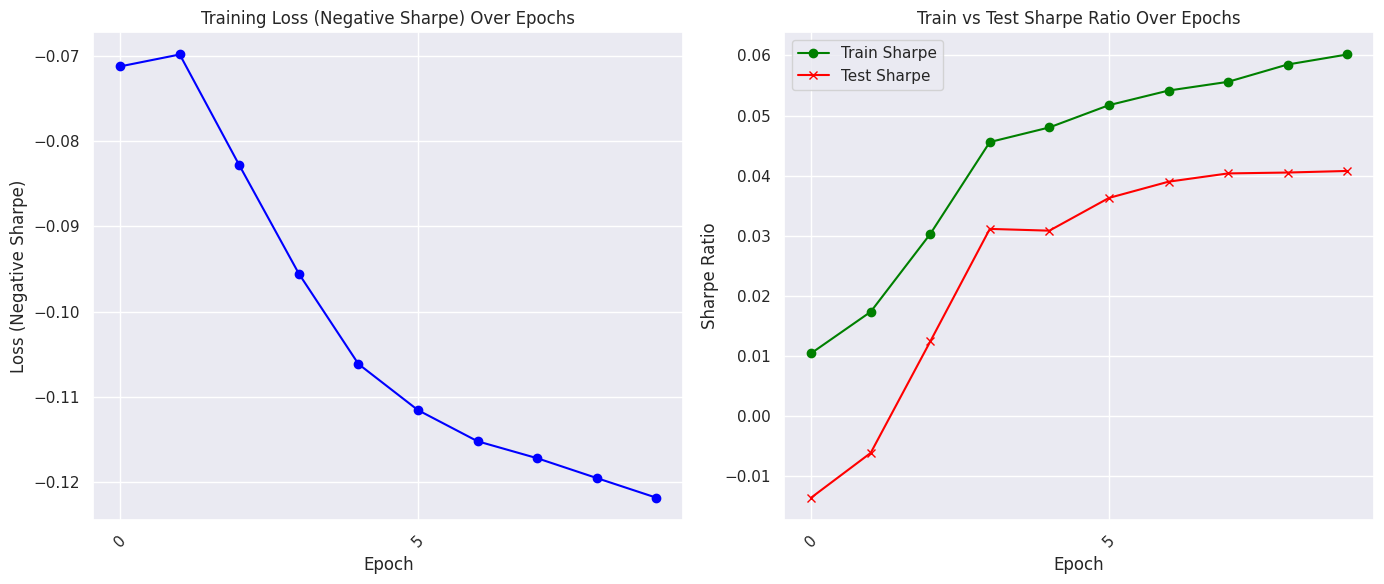

In [10]:
reload(utils) # In case the python module is modified
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

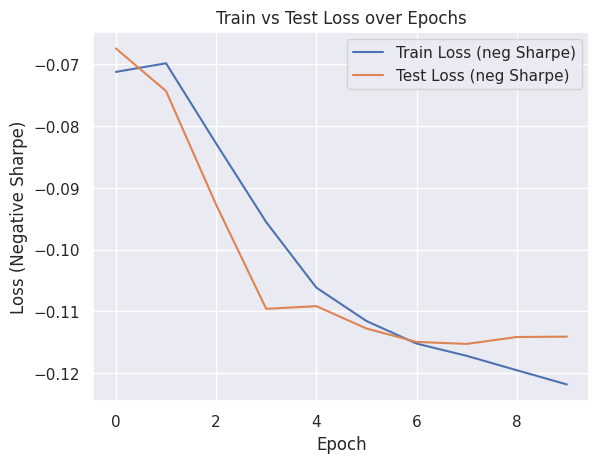

In [11]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

In [12]:
weights.describe()

count    1.664320e+05
mean     2.463469e-04
std      3.298238e-04
min      9.329235e-16
25%      1.360445e-05
50%      7.291374e-05
75%      4.045618e-04
max      2.302615e-03
dtype: float64

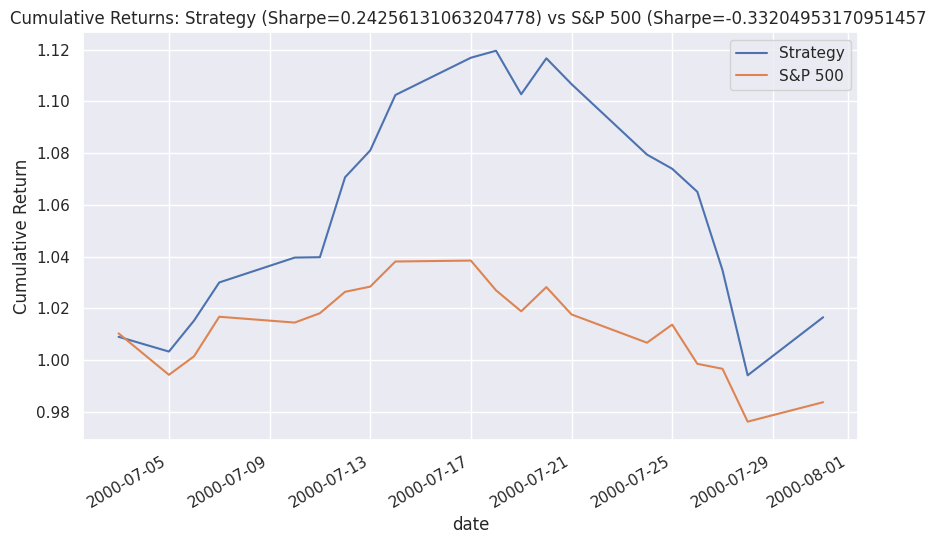

In [13]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

## Second run: reduce epochs, use 

It seems a high number of epochs isn't necessary for convergence. Actually, it reduces out of sample Sharpe ratio as it overfits the training data. We can train faster using less epochs and a higher learning rate. The above plots suggest 3 epochs is sufficient. However, since this is quite low, we first try with 10 and a faster learning rate of 0.01 instead of 0.001.